# Main Notebook

File to perform experiments

## Imports

In [1]:
import os
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm import tqdm
import tensorflow as tf

from models.GaussianProcess import GaussianProcess
from acquisition_functions.UseMO import usemo_acq
from acquisition_functions.MES import mes_acq, basic_mes_acq
from acquisition_functions.PESMO import pesmo_acq
from acquisition_functions.MESMO import mesmo_acq
from arguments.arguments import MainArguments

from MOObenchmark import MOOackley, MOOexponential, MOOquadratic_ackley, MOOnnHeartNeuronsProb
from utils.calc_pareto import get_pareto_undominated_by, getSetfromFront

from models.MOOEvaluationProblem import MOOEvaluationProblem

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_termination
from pymoo.optimize import minimize

2023-06-12 17:18:07.192568: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 17:18:07.233000: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 17:18:07.233416: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 17:18:07.815071: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Algorithm Arguments

In [2]:
d = 5 # input dimensions
    
seed = 0
np.random.seed(seed)

## iterations of the main algorithm
total_iter = 40
## iterations taken randomly at the beggining
initial_iter = 1

## bound of the inputs definition
### with the current implementations all the input dimensions must have the same bounds, 
### but this can be changed
lower_bound = 10
upper_bound = 1000

lowerBounds = [lower_bound]*d
upperBounds = [upper_bound]*d


## Evaluation

In [3]:
## Evaluation function definition
O = 2
C = 0

def evaluation(x):
    return MOOnnHeartNeuronsProb(x)

This cell below gets the real pareto in two ways: with a grid and with a cheap optimizer (genetic algorithm) and plots both of them. These results are used in test problems as the actual pareto front. Although, to obtain these paretos many evaluations of the function are needed, so it has no sense running it in a costly black box problem.

In addition this is only prepared to plot a d=1, O=2 problem. We could visualize any problem, but the visualization get a lot more abstract and more plots are needed. If this is interesting I could do it.

Therefore I set the code below as text.

N = 1_001
X = np.linspace(lower_bound,upper_bound,N)
Z = np.zeros((N,2))

problem = MOOEvaluationProblem(evaluation, O=O, d=d, lowerBounds=lower_bound, upperBounds=upper_bound)
algorithm = NSGA2()
res = minimize( problem, 
                algorithm,
                termination = get_termination("n_gen",100))

real_pareto = res.F[np.argsort(res.F[:,0])]

for i in range(N):
    Z[i]=evaluation(X[i])

fig, axs = plt.subplots(1,3, figsize=(15,4))

axs[0].plot(X, Z[:,0], 'b')
axs[0].plot(X, Z[:,1], 'k')
axs[0].plot(res.X, res.F[:,0], 'xr', markersize=5)
axs[0].plot(res.X, res.F[:,1], 'xr', markersize=5)

axs[1].plot(np.reshape(Z,(-1,2))[:,0], np.reshape(Z,(-1,2))[:,1], 'kx')
axs[1].plot(res.F[:,0], res.F[:,1], 'rx')
res
axs[2].plot(res.F[:,0], res.F[:,1], 'x')
plt.show()

In [4]:
def random_acq(GP: GaussianProcess, **kwargs):
    while True:
        x_rand = np.random.uniform(GP.lowerBounds, GP.upperBounds, GP.d)
        if GP.X is None or not x_rand in GP.X:
            break
    return x_rand

## N experiments

C = [206.18374515 403.96027025 503.46124155 950.24729175 503.67085992]
Epoch 1/6
1210/1210 [==============================] - 7s 4ms/step - loss: 0.5420 - val_loss: 0.5451
Epoch 2/6
1210/1210 [==============================] - 2s 2ms/step - loss: 0.5152 - val_loss: 0.5079
Epoch 3/6
1210/1210 [==============================] - 2s 2ms/step - loss: 0.5121 - val_loss: 0.5015
Epoch 4/6
1210/1210 [==============================] - 2s 2ms/step - loss: 0.5086 - val_loss: 0.4957
Epoch 5/6
1210/1210 [==============================] - 2s 2ms/step - loss: 0.5091 - val_loss: 0.5022
Epoch 6/6
135/135 [==============================] - 0s 690us/step
[[206.18374515 403.96027025 503.46124155 950.24729175 503.67085992]]
C = [749.21576767 258.2623585  826.98517695 217.01474133 653.3392806 ]
Epoch 1/6
1210/1210 [==============================] - 6s 4ms/step - loss: 0.5543 - val_loss: 0.5033
Epoch 2/6
1210/1210 [==============================] - 5s 4ms/step - loss: 0.5192 - val_loss: 0.5046
Epoch 3/6
1210/

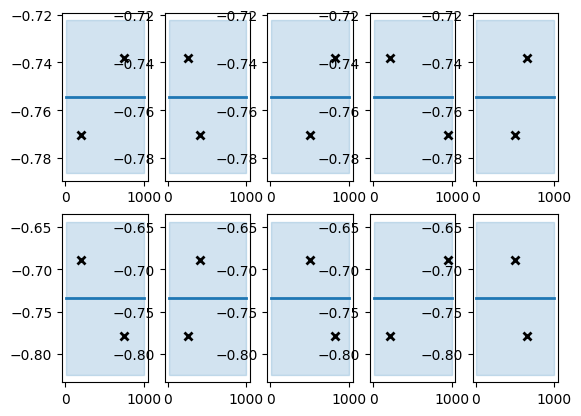

C = [522.73688152 819.31425318 728.76246734 664.69757427 675.27557698]
Epoch 1/6
 383/1210 [========>.....................] - ETA: 4s - loss: 0.6479

KeyboardInterrupt: 

In [13]:
savename = "MOONNHeart"

### GPs Initialization
GP = GaussianProcess(O, C, d, lowerBounds, upperBounds, noise_variance=2e-6)

#### Initial samples, at least 1
for l in range(initial_iter):
    ## Get random evaluation point
    while True:
        x_rand = np.random.uniform(lowerBounds[0], upperBounds[0], d)
        if GP.X is None or not x_rand in GP.X:
            break
    ## EVALUATION OF THE OUTSIDE FUNCTION
    
    y_rand = evaluation(x_rand)
    GP.X = np.array([x_rand], dtype=float)
    GP.Y = np.array([y_rand], dtype=float)

GP.updateGP()
GP.optimizeKernel()

print(GP.X)
if False:
    GP.plotSamples()

for l in range(total_iter):

    ## For all acq functions but usemo
    #x_best, acq_best = mes_acq(GP)
    ## For usemo
    x_best, acq_best = usemo_acq(GP, function = "ei", showplots = False)

    ## EVALUATION OF THE OUTSIDE FUNCTION
    y_best = evaluation(x_best)

    ## UPDATE
    GP.addSample(x_best,y_best)     ## Add new sample to the model
    GP.updateGP()                   ## Update data on the GP regressor
    GP.optimizeKernel()             ## Optimize kernel hyperparameters

    print("Iteration=", l, " x_best=", x_best, "y=", y_best)
    GP.plot()
    

## Evaluate results

As you are doing a real world experiment you do not have access to the real pareto front, then you fo noy hsbr yhr metrics as before (I removed them).

What you should evaluate is the results in terms of the best *y* possible. You have the data below, but you may do a pandas dataframe to store it cleaner when it is computed in the previous section.

GP.X === samples where the function was evaluated

GP.Y === results of those evaluations

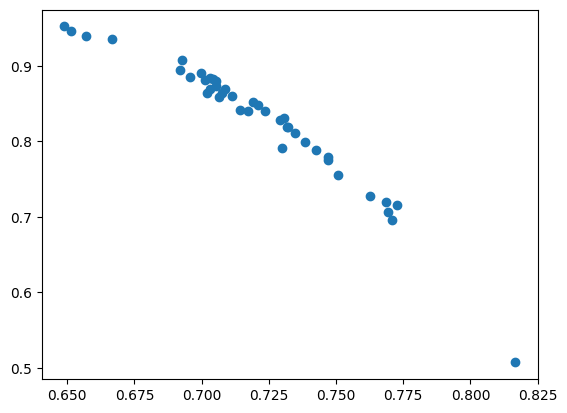

In [11]:
plt.scatter(-GP.Y[:,0],-GP.Y[:,1])

In [ ]:
from utils.calc_pareto import get_pareto_undominated_by

front = get_pareto_undominated_by(-GP.Y)

plt.scatter(front[:,0],front[:,1])

In [12]:
-GP.Y

array([[0.72924335, 0.82891678],
       [0.69279886, 0.90794979],
       [0.76923077, 0.70664807],
       [0.70415739, 0.88191539],
       [0.70192671, 0.86378429],
       [0.70303254, 0.88377499],
       [0.7054846 , 0.87308229],
       [0.70753998, 0.86378429],
       [0.73214286, 0.81961878],
       [0.66655618, 0.93491399],
       [0.77270447, 0.71594607],
       [0.74255692, 0.78847048],
       [0.77073673, 0.69549047],
       [0.71115385, 0.85960019],
       [0.73851438, 0.79962808],
       [0.76267057, 0.72756857],
       [0.70327191, 0.86936309],
       [0.72996142, 0.79172478],
       [0.71445498, 0.84100418],
       [0.73484848, 0.81171548],
       [0.76873449, 0.72013017],
       [0.71921569, 0.85262669],
       [0.73076923, 0.83031148],
       [0.69967117, 0.89028359],
       [0.70646766, 0.85820549],
       [0.72105887, 0.84844258],
       [0.74699332, 0.77963738],
       [0.69208633, 0.89446769],
       [0.7468638 , 0.77498838],
       [0.70887036, 0.86936309],
       [0.

In [ ]:
x_front = [GP.X[(-GP.Y).tolist().index(y)] for y in front.tolist()]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

front_test = []

data = pd.read_csv("heart_disease_health_indicators_BRFSS2015.csv")
X = data.drop("HeartDiseaseorAttack", axis=1)
y = data["HeartDiseaseorAttack"]

y_1 = y[y == 1]
y_used = pd.concat([y_1, y[y == 0].sample(len(y_1))])
X_used = X.iloc[y_used.index]

X_train_val, X_test, y_train_val, y_test = train_test_split(X_used, y_used, test_size=0.1, random_state=42, stratify=y_used)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42, stratify=y_train_val)

checkpoint_path = f"./Checkpoints"
checkpoint_dir = [f for f in os.listdir(checkpoint_path) if os.path.isfile(os.path.join(checkpoint_path, f)) and f.split(".")[-1]=="h5"]


for path in checkpoint_dir:
    print(path.split(".")[0].split("/")[-1].split("_")[-2:])
    arch = [int(x) for x in path.split(".")[0].split("/")[-1].split("_")[-2:]]
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(21, 1)),
      tf.keras.layers.Dense(int(np.around(arch[0])), activation='relu'),
      tf.keras.layers.Dense(int(np.around(arch[1])), activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    

    
    model.load_weights(path)
    
    y_pred = np.around(model.predict(X_test))
    
    front_test.append((precision_score(y_test, y_pred), recall_score(y_test, y_pred)))
    

In [ ]:
[x[0] for x in front_test]

plt.scatter([x[0] for x in front_test], [x[1] for x in front_test])

In [ ]:
front_test

In [ ]:
#!rm -rf Checkpoints